<a href="https://colab.research.google.com/github/martinpius/Behind-Keras-Layers-and-Models/blob/main/Subclassing_and_customization_of_kera's_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
from google.colab import drive
try:
  drive.mount("/content/drive", force_remount = True)
  COLAB = True
  import tensorflow as tf
  print(f"You are using Colab with tensorflow version {tf.__version__}")
except Exception as e:
  COLAB = False
  print(f"{type(e)}: {e}\n....Please Load Your Drive....")

Mounted at /content/drive
You are using Colab with tensorflow version 2.3.0


In [67]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [68]:
#Adding customized regularizer to a keras model. This will finaly added directly to the main
#loss during training
#We may train our model directly using regularizer as the only loss function

In [69]:
#Consider a simple example of a regularizer which adjust the input/weights at any layer

In [70]:
class MyREgularizer(keras.layers.Layer):
  '''This class will adjust the weights/inputs at any layer desired'''
  def call(self, inputs):
    self.add_loss(tf.reduce_sum(inputs) * 0.1)
    return inputs

In [71]:
#Consider a simple MLP for mnist dataset
inputs = keras.Input(shape = (784,), name = 'mnist')
x = keras.layers.Dense(units = 64, kernel_initializer = 'random_normal', activation = 'relu')(inputs)
x = MyREgularizer()(x)
x = keras.layers.Dense(units = 64, kernel_initializer = 'random_normal', activation = 'relu')(x)
outputs = keras.layers.Dense(units = 10, activation = 'softmax')(x)

In [72]:
model = keras.Model(inputs = inputs, outputs = outputs, name = 'mlp_with_regularizer')

In [73]:
model.summary()

Model: "mlp_with_regularizer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mnist (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                50240     
_________________________________________________________________
my_r_egularizer_1 (MyREgular (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


In [74]:
#Load mnist dataset from keras
(x_train, y_train),(x_test,y_test) = tf.keras.datasets.mnist.load_data()

In [75]:
#print out the shape
print(f"x_train_shape: {x_train.shape}, x_test.shape: {x_test.shape}\ny_train.shape : {y_train.shape}, y_test.shape: {y_test.shape}")

x_train_shape: (60000, 28, 28), x_test.shape: (10000, 28, 28)
y_train.shape : (60000,), y_test.shape: (10000,)


In [76]:
#Reshape and preprocess (rescale into values between 0-1)
x_train, x_test = x_train.reshape(60000, 784).astype('float32')/255.0, x_test.reshape(10000, 784).astype('float32')/255.0

In [77]:
#Convert the label to one-hot vector (we will use a customized loss function)
y_train, y_test = tf.one_hot(y_train, depth = 10), tf.one_hot(y_test, depth = 10)

In [78]:
#Customized loss
class MyLoss(keras.losses.Loss):
  def __init__(self, name = 'mse',**kwargs):
    super(MyLoss, self).__init__(name = name, **kwargs)
  def call(self, y_real, y_hat):
    loss = tf.math.reduce_mean(tf.square(y_real - y_hat))
    return loss


In [79]:
model.compile(loss = MyLoss(), optimizer = 'Adam') #We can compile our model using our custome loss

In [80]:
model.fit(x_train, y_train, validation_data= (x_test, y_test), epochs = 2, verbose = 2)

Epoch 1/2
1875/1875 - 3s - loss: 0.1651 - val_loss: 0.0901
Epoch 2/2
1875/1875 - 3s - loss: 0.0900 - val_loss: 0.0901


In [81]:
#Adding the loss function through add_loss prevent the need to add a loss argument during compilation
#Consider the following binary classification problem (logistic loss)

In [82]:
class MyLogistic(keras.layers.Layer):
  def __init__(self, name = None):
    super(MyLogistic, self).__init__(name = name)
    self.loss_fn = keras.losses.BinaryCrossentropy(from_logits = True)
    self.metric_fn = keras.metrics.BinaryAccuracy(name = 'accuracy')

  def call(self, y_real, y_hat, sample_weights = None):
    loss = self.loss_fn(y_real,y_hat, sample_weights) #get the loss
    metric = self.metric_fn(y_real, y_hat, sample_weights)#get the metrics
    self.add_loss(loss)# get the loss
    self.add_metric(metric)
    return tf.nn.softmax(y_hat)


In [83]:
#Using the above loss function we can train a simple MLP as follows
inputs = keras.Input(shape = (10,), name = 'inputs')
y_real = keras.Input(shape = (5,), name = 'labels')
y_hat = keras.layers.Dense(units = 5)(y_real)
preds = MyLogistic(name = 'predictions')(y_real, y_hat)


In [84]:
model = keras.Model(inputs = [inputs, y_real], outputs = preds)

In [85]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
labels (InputLayer)             [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 5)            30          labels[0][0]                     
__________________________________________________________________________________________________
inputs (InputLayer)             [(None, 10)]         0                                            
__________________________________________________________________________________________________
predictions (MyLogistic)        (None, 5)            2           labels[0][0]                     
                                                                 dense_10[0][0]        

In [86]:
model.compile(optimizer = 'Adam')

In [87]:
#Create some toy data to try the model

In [88]:
dfm = {'inputs': np.random.random((5,10)),
       'y_real': np.random.random((5, 5))}

In [89]:
model.fit(dfm, epochs = 3)

Epoch 1/3
1/1 [==============================] - 0s 1ms/step - loss: 0.7247 - accuracy: 0.0000e+00
Epoch 2/3
1/1 [==============================] - 0s 1ms/step - loss: 0.7243 - accuracy: 0.0000e+00
Epoch 3/3
1/1 [==============================] - 0s 2ms/step - loss: 0.7239 - accuracy: 0.0000e+00


In [90]:
#We can sometimes train our model using a very large dataset. Since we cannot fit everything in memory we 
#may want to streams in data in batches. numpy arrays are not suitable for this case and thus we need
#to create a tensoflow dataset.
#Consider our previous mnist example


In [91]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [92]:
#Preprocess the data
x_train, x_test = x_train.reshape(60000, 784).astype('float32')/255.0, x_test.reshape(10000, 784).astype('float32')/255.0
y_train, y_test = tf.keras.utils.to_categorical(y_train, num_classes = 10), tf.keras.utils.to_categorical(y_test, num_classes = 10)

In [93]:
#Convert to tensorflow dataset
train_dfm = tf.data.Dataset.from_tensor_slices((x_train, y_train))

In [94]:
test_dfm = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [95]:
#Shuffle and splits the training dataset for streaming
train_dfm = train_dfm.shuffle(buffer_size = 1024).batch(64) #We will stream the data in batches of size 64. we will not consider the batch argument again


In [96]:
test_dfm = test_dfm.batch(64)

In [97]:
#Now we can fit our simple mlp designed  by passing the data in the tensorflow splited format
inputs = keras.Input(shape = (784,), name = 'mnist')
x = keras.layers.Dense(units = 64, activation = 'relu', kernel_initializer = 'random_normal')(inputs)
x = keras.layers.Dense(units = 64, activation = 'relu', kernel_initializer = 'random_normal')(x)
outputs = keras.layers.Dense(units = 10, activation = 'softmax')(x)
model = keras.models.Model(inputs = inputs, outputs = outputs)


In [98]:
model.compile(loss = 'CategoricalCrossentropy',
              optimizer = 'Adam',
              metrics = ['accuracy'])

In [99]:
model.fit(train_dfm, epochs = 5, verbose = 2) #We dont need to pass batch argument

Epoch 1/5
938/938 - 2s - loss: 0.3440 - accuracy: 0.9003
Epoch 2/5
938/938 - 2s - loss: 0.1561 - accuracy: 0.9538
Epoch 3/5
938/938 - 2s - loss: 0.1146 - accuracy: 0.9654
Epoch 4/5
938/938 - 2s - loss: 0.0906 - accuracy: 0.9727
Epoch 5/5
938/938 - 2s - loss: 0.0743 - accuracy: 0.9775


In [100]:
results = model.evaluate(test_dfm, verbose = 2)

157/157 - 0s - loss: 0.0977 - accuracy: 0.9697


In [101]:
print(f"loss: {results[0]:.4f}, accuracy: {results[1]:.4f}")

loss: 0.0977, accuracy: 0.9697


In [102]:
##Passing data to multi input-output model

In [103]:
#We can also passing multiple inputs to obtain multiple outputs in keras model
#Consider the following survival problem which classify individual risks of death due to 
#particular event and also we may be interested to comput survival scores(time) of each individual

In [104]:
inputs1 = keras.Input(shape = (32,32,3), name = 'img')
inputs2 = keras.Input(shape = (None, 10), name = 'others')
x1 = keras.layers.Conv2D(filters = 32, kernel_size = (3,3), strides = (2,2), padding = 'same',activation = 'relu', name = 'layer_1A')(inputs1)
x1 = keras.layers.GlobalMaxPooling2D()(x1)
x2 = keras.layers.Conv1D(filters = 32, kernel_size = 3, activation = 'relu',name = 'layer_1B')(inputs2)
x2 = keras.layers.GlobalMaxPooling1D()(x2)
x = keras.layers.concatenate([x1,x2]) #Fuse the layers from different inputs
outputs1 = keras.layers.Dense(units = 10, activation = 'softmax', name = 'risks_classes')(x)#risks classes
outputs2 = keras.layers.Dense(units = 1, name = 'survival_scores')(x) #survival scores

In [105]:
model = keras.Model(inputs = [inputs1, inputs2], outputs = [outputs1, outputs2], name = 'multiple in-out')

In [106]:
model.summary()

Model: "multiple in-out"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
others (InputLayer)             [(None, None, 10)]   0                                            
__________________________________________________________________________________________________
layer_1A (Conv2D)               (None, 16, 16, 32)   896         img[0][0]                        
__________________________________________________________________________________________________
layer_1B (Conv1D)               (None, None, 32)     992         others[0][0]                     
____________________________________________________________________________________

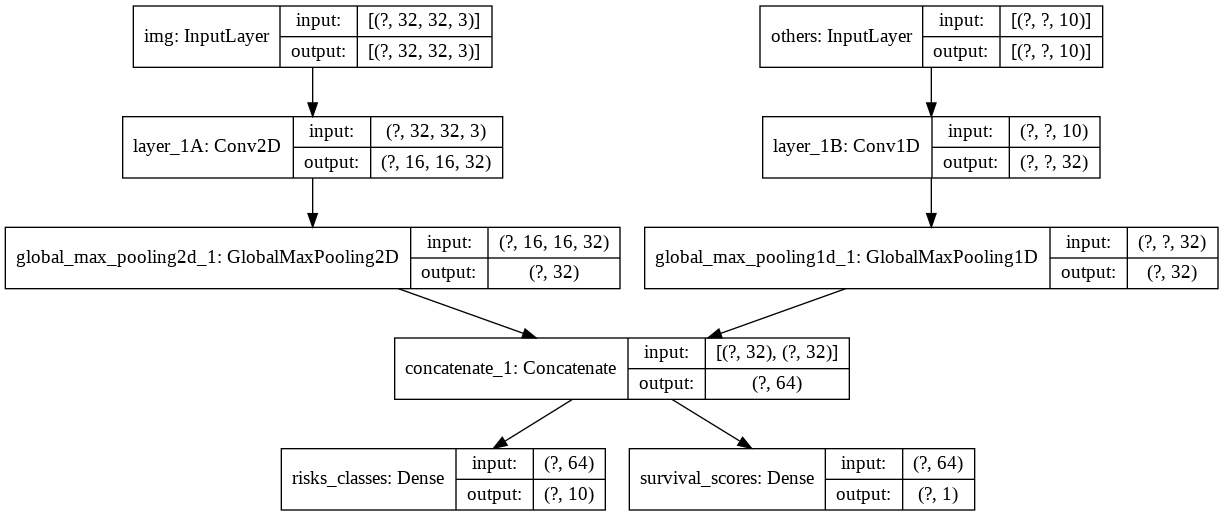

In [107]:
keras.utils.plot_model(model, 'mymodel.png', show_shapes = True) #Get the vissual graph

In [108]:
#We can compile the model using multiple loss functions and list of several metrics if we can

In [109]:
model.compile(
    loss = {'risk_classes': keras.losses.CategoricalCrossentropy(),
            'survival_scores': keras.losses.MeanSquaredError()},
            optimizer = 'Adam',
            metrics = {
                'risk_classes': keras.metrics.CategoricalAccuracy(),
                'survival_scores': [keras.metrics.MeanAbsolutePercentageError(),
                                    keras.metrics.MeanAbsoluteError()]
            },
            loss_weights = {'risk_classes':2.0, 'survival_scores': 1.0}
)

In [110]:
#Appliying callbacks in keras models
#Callbacks are necessary for various purposes such as checkpoing (when training on big data)
# and can also imposes early stopage in case validation loss is not improving

In [111]:
#Implimenting early stopage using the callbacks
from tensorflow.keras.callbacks import EarlyStopping


In [112]:
callback_info = EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 1, min_delta = 1e-3,restore_best_weights = True, mode = 'auto')

In [113]:
#Using the above callbacks in training
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [114]:
x_train, x_test = x_train.reshape(60000,784).astype('float')/255.0, x_test.reshape(10000, 784).astype('float')/255.0

In [115]:
y_train, y_test = tf.keras.utils.to_categorical(y_train, num_classes = 10), tf.keras.utils.to_categorical(y_test, num_classes = 10)

In [116]:
#Create a simple MLP for the mnist data
def mlp_sample():
  inputs = keras.Input(shape = (784,), name = 'mnist')
  x = keras.layers.Dense(units = 64, activation = 'relu', kernel_initializer = 'random_normal', name = 'layer_1')(inputs)
  x = keras.layers.Dense(units = 64, activation = 'relu', kernel_initializer = 'random_normal', name = 'layer_2')(x)
  outputs = keras.layers.Dense(units = 10, activation = 'softmax', name = 'classes')(x)
  model = keras.Model(inputs = inputs, outputs = outputs, name = 'mlp_with_callbacks')
  summary = model.summary()
  graph = tf.keras.utils.plot_model(model, 'mymodel.png', show_shapes = True)
  return model

In [117]:
def compiled_model():
  model = mlp_sample()
  model.compile(loss = 'CategoricalCrossentropy',
              optimizer = 'Adam', metrics = ['accuracy'])
  return model

In [119]:
model = compiled_model()
model.fit(x_train, y_train, validation_data = (x_test, y_test), callbacks = [callback_info], epochs = 100,verbose = 2)

Model: "mlp_with_callbacks"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mnist (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
layer_1 (Dense)              (None, 64)                50240     
_________________________________________________________________
layer_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
classes (Dense)              (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1875/1875 - 3s - loss: 0.3032 - accuracy: 0.9121 - val_loss: 0.1593 - val_accuracy: 0.9518
Epoch 2/100
1875/1875 - 3s - loss: 0.1346 - accuracy: 0.9592 - val_loss: 0.1291 - val_accuracy: 0.9610
Epoch 3/100
1875/1875 - 3s - loss: 0

In [120]:
#Checkpoing the model

In [121]:
model = compiled_model()
chekpoint = keras.callbacks.ModelCheckpoint(filepath = 'my_sample_model',monitor = 'val_loss',verbose = 1, save_best_only= True, save_freq='epoch')
model.fit(x_train, y_train, validation_data = (x_test, y_test), verbose = 2, callbacks = [callback_info, chekpoint], epochs = 100)

Model: "mlp_with_callbacks"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mnist (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
layer_1 (Dense)              (None, 64)                50240     
_________________________________________________________________
layer_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
classes (Dense)              (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.15426, saving model to my_sample_model
INFO:tensorflow:Assets written to: my_sample_model/assets
1875/1875 - 3s - loss: 0.3089 - accuracy: 0.9107 - val_loss: 0.1543 - val_accuracy: 0.9

In [122]:
#We can use checkpoint to resume training incase of any interuption  

In [123]:
import os

In [124]:
mychek_dir = './mycheckpoint'

In [125]:
#Create a directory to store the checkpoints
if not os.path.exists(mychek_dir):
  os.makedirs(mychek_dir)

In [126]:
#We can recover our model from the directory if it is there otherwise we can build a new model
def mymodel_recover_build():
  chkpnt = [mychek_dir + '/' + name for name in os.listdir(mychek_dir)] #A list comprehension to return all checkpoints as a list
  if chkpnt:
    latest_chkpnt = max(chkpnt, key = os.path.getctime)
    print(f" we are recovering from the latest checkpoint {latest_chkpnt}")
    return keras.models.load_model(latest_chkpnt) #Load the model at the point it was before interuption
  else:
    print("There is nothing in the directory. We create the new model")
    return compiled_model()


In [127]:
#Call the above function to create or to restore the model
model = mymodel_recover_build()
mycallback = keras.callbacks.ModelCheckpoint(filepath = mychek_dir +"/checkpoint_loss ={loss:.2f}", save_freq = 60)

There is nothing in the directory. We create the new model
Model: "mlp_with_callbacks"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mnist (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
layer_1 (Dense)              (None, 64)                50240     
_________________________________________________________________
layer_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
classes (Dense)              (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


In [128]:
model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 10, verbose = 2, callbacks = mycallback)

Epoch 1/10
INFO:tensorflow:Assets written to: ./mycheckpoint/checkpoint_loss =1.53/assets
INFO:tensorflow:Assets written to: ./mycheckpoint/checkpoint_loss =1.07/assets
INFO:tensorflow:Assets written to: ./mycheckpoint/checkpoint_loss =0.87/assets
INFO:tensorflow:Assets written to: ./mycheckpoint/checkpoint_loss =0.74/assets
INFO:tensorflow:Assets written to: ./mycheckpoint/checkpoint_loss =0.66/assets
INFO:tensorflow:Assets written to: ./mycheckpoint/checkpoint_loss =0.60/assets
INFO:tensorflow:Assets written to: ./mycheckpoint/checkpoint_loss =0.56/assets
INFO:tensorflow:Assets written to: ./mycheckpoint/checkpoint_loss =0.53/assets
INFO:tensorflow:Assets written to: ./mycheckpoint/checkpoint_loss =0.50/assets
INFO:tensorflow:Assets written to: ./mycheckpoint/checkpoint_loss =0.48/assets
INFO:tensorflow:Assets written to: ./mycheckpoint/checkpoint_loss =0.46/assets
INFO:tensorflow:Assets written to: ./mycheckpoint/checkpoint_loss =0.44/assets
INFO:tensorflow:Assets written to: ./mych